In [1]:
from glob import glob
import numpy as np
import json
import pandas as pd

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
data = 'cifar100'

# Test Accuracy Comparison

In [3]:
def summarize_final_results(data='cifar10', split='test', n_last=20):
    '''
    Calculate the mean and standard deviation of results of the last 'n_last' epochs.
    '''

    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['erm','mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            try:
                exp_name = '{}_{}_{}'.format(data, model, str(sample))
                path_list = sorted(
                            glob(
                                '../experiments/{}/{}.*@{}-1/accuracies.txt'.format(model, data, sample)
                            ))
                tmp = []
                for path in path_list:
                    f = json.load(open(path, "r"))
                    tmp.append(pd.DataFrame(f, index=split_list))
                try:
                    tmp = pd.concat(tmp, sort=False)
                    tmp_test = tmp.loc['test'].iloc[:,-n_last:]
                except:
                    print('Based on the only one seed', model, sample, len(path_list))
                    tmp_test = tmp.loc['test'].iloc[-n_last:]

                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                            'mean': tmp_test.mean().mean(),
                            'std': tmp_test.std().mean()}
                df = df.append(tmp_dict, ignore_index=True)
            except:
                print(model, data, sample)
                pass

    return df

In [4]:
def show_summary_plot(data='cifar10'):
    df_data = summarize_final_results(data=data, n_last=20)
    if data == 'cifar10':
        x_list = [100,500,1000,2500,5000,25000,50000] # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = [1000,2500,5000,25000,50000] # np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    models=['erm','mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    names=['ERM','Mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    colors=['gray', 'red', 'skyblue', 'dodgerblue','blue', 'darkslateblue', 'navy']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel('Test accuracy (in %)', fontsize=15)
    plt.title('Dataset: {}'.format(data), fontsize=15)
    
    for i in range(len(colors)):
        ymean = df_data['mean'][df_data['model']==models[i]]
        yerr = df_data['std'][df_data['model']==models[i]]
        plt.plot(np.log(x_list), ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
        plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
    
    #plt.ylim(86,88)
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()
    

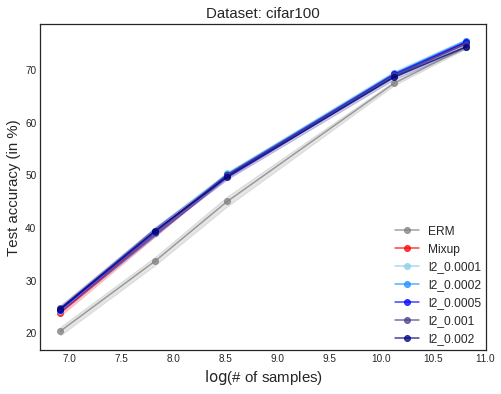

In [5]:
show_summary_plot(data=data)

In [6]:
def summary_table(data='cifar10'):
    df_data = summarize_final_results(data, n_last=20)
    ncol = 2 + len(df_data['model'].drop_duplicates())
    nrow = 1 + len(df_data['sample'].drop_duplicates())
    model_names = [data.replace('_', '-') for data in df_data['model'].drop_duplicates()]
    line = str(r'\begin{tabular}{|' + 'c|'*ncol + '}\n'
               + r'\hline' + '\n'
              )
    line = line + r'Dataset & Sample size'
    for model_name in model_names:
        line = line + ' & ' + model_name
    line = line + r'\tabularnewline' + '\n'
    line = line + str(r'\hline' + '\n'
                      + r'\hline' + '\n'
                      + r'\multirow{5}{*}{%s}' % df_data['data'][0] + '\n'
                     ) 
    for sample in sorted(df_data['sample'].drop_duplicates()):
        line = line + '& %d ' % sample
        for model in df_data['model'].drop_duplicates():
            ind = (df_data['sample'] == sample) & (df_data['model'] == model)
            line = line + r'& %.2f $\pm$ %.2f ' % (df_data['mean'][ind], df_data['std'][ind])
        line = line + r'\tabularnewline' + '\n'
        line = line + r'\cline{2-%d}' % ncol + '\n'
    line = line[:-12]
    line = line + r'\hline' + '\n' + r'\end{tabular}'
    return line

In [7]:
print(summary_table(data=data))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar100}
& 1000 & 20.41 $\pm$ 0.81 & 23.94 $\pm$ 0.65 & 24.31 $\pm$ 0.28 & 24.40 $\pm$ 0.39 & 24.46 $\pm$ 0.58 & 24.75 $\pm$ 0.61 & 24.65 $\pm$ 0.41 \tabularnewline
\cline{2-9}
& 2500 & 33.76 $\pm$ 0.79 & 39.05 $\pm$ 0.62 & 39.47 $\pm$ 0.77 & 39.15 $\pm$ 0.44 & 39.32 $\pm$ 0.61 & 39.34 $\pm$ 0.79 & 39.51 $\pm$ 0.64 \tabularnewline
\cline{2-9}
& 5000 & 45.06 $\pm$ 0.95 & 50.01 $\pm$ 0.24 & 50.37 $\pm$ 0.26 & 50.20 $\pm$ 0.38 & 49.99 $\pm$ 0.46 & 50.14 $\pm$ 0.29 & 49.69 $\pm$ 0.43 \tabularnewline
\cline{2-9}
& 25000 & 67.52 $\pm$ 0.40 & 69.24 $\pm$ 0.29 & 69.15 $\pm$ 0.35 & 69.37 $\pm$ 0.47 & 69.20 $\pm$ 0.20 & 69.02 $\pm$ 0.26 & 68.66 $\pm$ 0.42 \tabularnewline
\cline{2-9}
& 50000 & 74.36 $\pm$ 0.26 & 75.29 $\pm$ 0.21 & 75.60 $\pm$ 0.30 & 75.59 $\pm$ 0.33 & 75.34 $\pm$ 0.34 & 74.97 $\pm$ 0.26 & 74.41 $\pm

# Experiments with Noisy Image

In [8]:
def summarize_noise_results(data='cifar10', **kwargs):
    '''
    Calculate the mean and standard deviation of accuracies with noisy images.
    '''

    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    mean = kwargs.get('mean', 0)
    var = kwargs.get('var', None)
    mode = kwargs.get('mode', None)
    p = kwargs.get('p', None)
    if mode is 'gaussian':
        noise_settings = {'Mode':'gaussian', 'Mean':mean, 'Var':var, 'seed':None}
    elif mode is not None:
        noise_settings = {'Mode':mode, 'p':p, 'seed':None}
    else:
        assert False, 'mode is None'
    
    models = ['erm','mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    split_list = ['noise_tr','noise_val','noise_test','gap_tr','gap_val','gap_test']
    df = pd.DataFrame(columns=['data','model','sample','noise_settings',
                               'noise_tr_mean','noise_tr_std','noise_test_mean','noise_test_std',
                               'gap_tr_mean','gap_tr_std','gap_test_mean','gap_test_std',])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(
                        glob(
                            '../experiments/{}/{}.*@{}-1/noise.txt'.format(model, data, sample)
                        ))
            tmp = []
            for path in path_list:
                f = json.load(open(path, "r"))
                acc = f[str(noise_settings)]
                # acc: [noise_tr, noise_val, noise_test, tr, val, test]
                acc[3] = acc[0] - acc[3]
                acc[4] = acc[1] - acc[4]
                acc[5] = acc[2] - acc[5]
                tmp.append(pd.DataFrame(acc, index=split_list))
            tmp = pd.concat(tmp, sort=False)
            tmp_mean = tmp.groupby(level=0).mean()
            tmp_std = tmp.groupby(level=0).std()
            tmp_dict = {'data': data,
                        'model': model,
                        'sample': sample,
                        'noise_settings':str(noise_settings),
                        'noise_tr_mean': tmp_mean.loc['noise_tr'].iloc[0],
                        'noise_tr_std': tmp_std.loc['noise_tr'].iloc[0],
                        'noise_test_mean': tmp_mean.loc['noise_test'].iloc[0],
                        'noise_test_std': tmp_std.loc['noise_test'].iloc[0],
                        'gap_tr_mean': tmp_mean.loc['gap_tr'].iloc[0],
                        'gap_tr_std': tmp_std.loc['gap_tr'].iloc[0],
                        'gap_test_mean': tmp_mean.loc['gap_test'].iloc[0],
                        'gap_test_std': tmp_std.loc['gap_test'].iloc[0]
                       }
            df = df.append(tmp_dict, ignore_index=True)
    return df

In [9]:
def show_noise_plot(data='cifar10', split='train', **kwargs):
    df_data = summarize_noise_results(data=data, **kwargs)
    if data == 'cifar10':
        x_list = [100,500,1000,2500,5000,25000,50000] # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = [1000,2500,5000,25000,50000] # np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    models=['erm','mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    names=['ERM','Mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    colors=['gray', 'red', 'skyblue', 'dodgerblue', 'blue', 'darkslateblue', 'navy']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel('Accuracy (in %)', fontsize=15)
    plt.title('Dataset: {}, Noise:{}'.format(data, df_data['noise_settings'][0]), fontsize=15)
    
    if split is 'train':
        for i in range(len(colors)):
            #train plot
            #ymean = df_data['tr_mean'][df_data['model']==models[i]]
            #yerr = df_data['tr_std'][df_data['model']==models[i]]
            #plt.plot(np.log(x_list), ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
            #plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
            #noise plot
            ymean = df_data['noise_tr_mean'][df_data['model']==models[i]]
            yerr = df_data['noise_tr_std'][df_data['model']==models[i]]
            plt.plot(np.log(x_list), ymean, '--', marker='o', color=colors[i], alpha=0.5) 
            plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.1, edgecolor=colors[i], facecolor=colors[i])
    elif split is 'test':
        for i in range(len(colors)):
            #test plot
            #ymean = df_data['test_mean'][df_data['model']==models[i]]
            #yerr = df_data['test_std'][df_data['model']==models[i]]
            #plt.plot(np.log(x_list), ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
            #plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
            #test plot
            ymean = df_data['noise_test_mean'][df_data['model']==models[i]]
            yerr = df_data['noise_test_std'][df_data['model']==models[i]]
            plt.plot(np.log(x_list), ymean, '--', marker='o', color=colors[i], label=names[i], alpha=0.75) 
            plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.3, edgecolor=colors[i], facecolor=colors[i])
    else:
        assert False, 'check split (train or test)'
    #plt.ylim(75,88)
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()

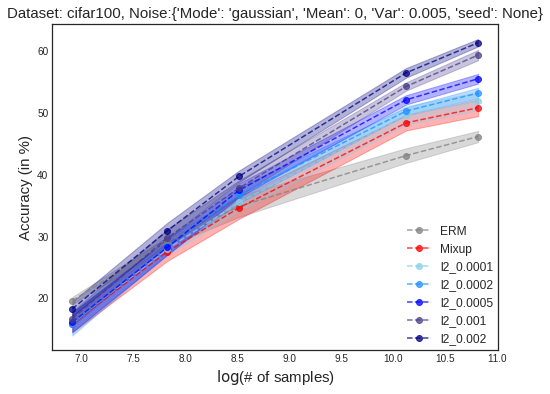

In [10]:
show_noise_plot(data=data, split='test', mode='gaussian', var=0.005)

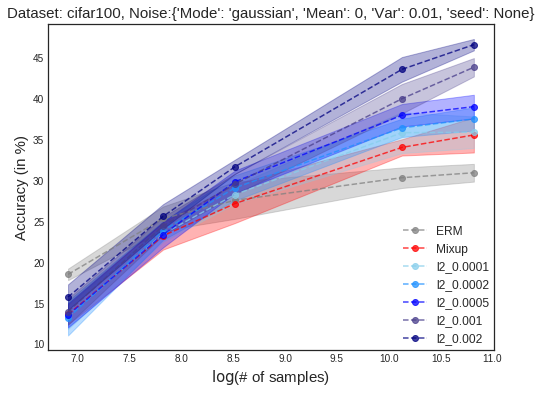

In [11]:
show_noise_plot(data=data, split='test', mode='gaussian', var=0.01)

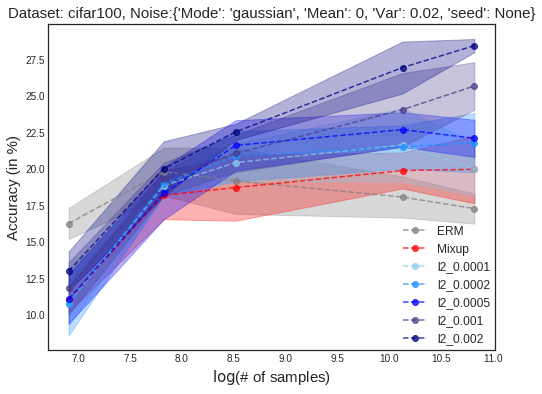

In [12]:
show_noise_plot(data=data, split='test', mode='gaussian', var=0.02)

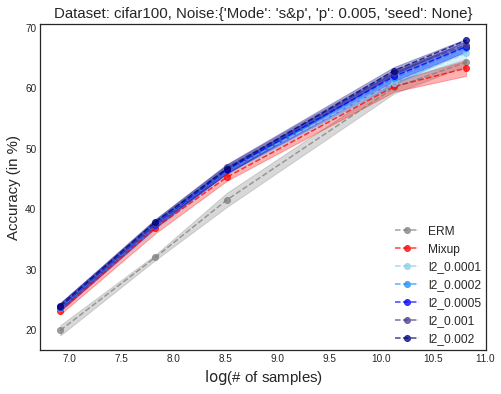

In [13]:
show_noise_plot(data=data, split='test', mode='s&p', p=0.005)

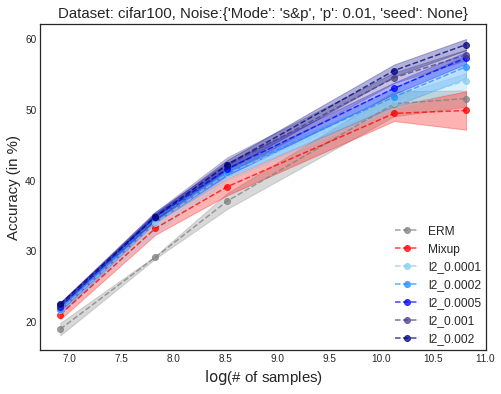

In [14]:
show_noise_plot(data=data, split='test', mode='s&p', p=0.01)

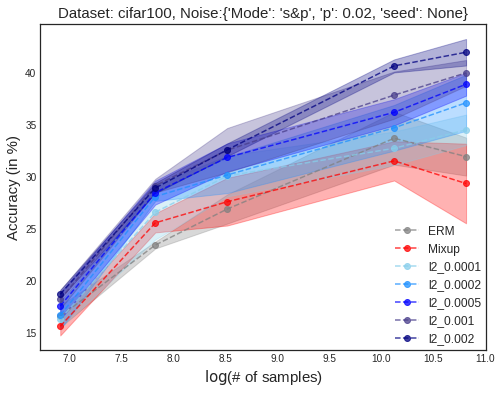

In [15]:
show_noise_plot(data=data, split='test', mode='s&p', p=0.02)

In [16]:
def summary_noise_table(data=data, split='test', **kwargs):
    df_data = summarize_noise_results(data, split=split, **kwargs)
    ncol = 2 + len(df_data['model'].drop_duplicates())
    nrow = 1 + len(df_data['sample'].drop_duplicates())
    model_names = [data.replace('_', '-') for data in df_data['model'].drop_duplicates()]
    line = str(r'\begin{tabular}{|' + 'c|'*ncol + '}\n'
               + r'\hline' + '\n'
              )
    line = line + r'Dataset & Sample size'
    for model_name in model_names:
        line = line + ' & ' + model_name
    line = line + r'\tabularnewline' + '\n'
    line = line + str(r'\hline' + '\n'
                      + r'\hline' + '\n'
                      + r'\multirow{5}{*}{%s}' % df_data['data'][0] + '\n'
                     ) 
    for sample in sorted(df_data['sample'].drop_duplicates()):
        if split is 'test':
            mean_ind, std_ind = 'noise_test_mean', 'noise_test_std'
        elif split is 'train':
            mean_ind, std_ind = 'noise_tr_mean', 'noise_tr_std'
        else:
            assert False, 'split must be train or test'
        line = line + '& %d ' % sample
        for model in df_data['model'].drop_duplicates():
            ind = (df_data['sample'] == sample) & (df_data['model'] == model)
            line = line + r'& %.2f $\pm$ %.2f ' % (df_data[mean_ind][ind], df_data[std_ind][ind])
        line = line + r'\tabularnewline' + '\n'
        line = line + r'\cline{2-%d}' % ncol + '\n'
    line = line[:-12]
    line = line + r'\hline' + '\n' + r'\end{tabular}'
    return line

In [17]:
print(summary_noise_table(data=data, mode='gaussian', var=0.005))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar100}
& 1000 & 19.64 $\pm$ 0.58 & 15.89 $\pm$ 1.40 & 16.01 $\pm$ 1.30 & 15.89 $\pm$ 1.89 & 16.14 $\pm$ 1.58 & 16.72 $\pm$ 1.18 & 18.30 $\pm$ 1.17 \tabularnewline
\cline{2-9}
& 2500 & 29.17 $\pm$ 0.74 & 27.55 $\pm$ 1.50 & 28.00 $\pm$ 1.02 & 28.41 $\pm$ 1.21 & 28.25 $\pm$ 1.24 & 29.81 $\pm$ 1.38 & 30.93 $\pm$ 1.28 \tabularnewline
\cline{2-9}
& 5000 & 34.89 $\pm$ 1.72 & 34.66 $\pm$ 1.79 & 35.52 $\pm$ 1.31 & 36.71 $\pm$ 1.28 & 37.50 $\pm$ 1.11 & 37.85 $\pm$ 1.25 & 39.74 $\pm$ 0.94 \tabularnewline
\cline{2-9}
& 25000 & 43.08 $\pm$ 1.18 & 48.37 $\pm$ 1.23 & 49.58 $\pm$ 1.52 & 50.27 $\pm$ 0.61 & 52.09 $\pm$ 0.76 & 54.25 $\pm$ 0.67 & 56.45 $\pm$ 0.78 \tabularnewline
\cline{2-9}
& 50000 & 46.15 $\pm$ 0.91 & 50.79 $\pm$ 1.35 & 51.85 $\pm$ 1.46 & 53.18 $\pm$ 0.85 & 55.49 $\pm$ 0.78 & 59.31 $\pm$ 0.84 & 61.31 $\pm

In [18]:
print(summary_noise_table(data=data, mode='gaussian', var=0.01))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar100}
& 1000 & 18.55 $\pm$ 0.71 & 13.66 $\pm$ 1.22 & 13.46 $\pm$ 1.58 & 13.21 $\pm$ 2.13 & 13.55 $\pm$ 1.48 & 14.00 $\pm$ 1.61 & 15.78 $\pm$ 1.56 \tabularnewline
\cline{2-9}
& 2500 & 25.39 $\pm$ 1.47 & 23.27 $\pm$ 1.68 & 23.50 $\pm$ 0.94 & 23.92 $\pm$ 1.14 & 23.41 $\pm$ 1.56 & 24.47 $\pm$ 1.11 & 25.64 $\pm$ 1.49 \tabularnewline
\cline{2-9}
& 5000 & 27.61 $\pm$ 2.26 & 27.21 $\pm$ 2.38 & 28.31 $\pm$ 1.11 & 29.13 $\pm$ 1.54 & 29.87 $\pm$ 1.38 & 29.60 $\pm$ 1.25 & 31.71 $\pm$ 0.87 \tabularnewline
\cline{2-9}
& 25000 & 30.37 $\pm$ 1.26 & 34.07 $\pm$ 1.00 & 35.87 $\pm$ 2.49 & 36.46 $\pm$ 1.12 & 38.00 $\pm$ 1.38 & 40.02 $\pm$ 1.80 & 43.61 $\pm$ 1.50 \tabularnewline
\cline{2-9}
& 50000 & 30.97 $\pm$ 1.08 & 35.59 $\pm$ 2.15 & 35.92 $\pm$ 1.93 & 37.56 $\pm$ 1.41 & 39.05 $\pm$ 1.45 & 43.87 $\pm$ 1.12 & 46.63 $\pm

In [19]:
print(summary_noise_table(data=data, mode='gaussian', var=0.02))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar100}
& 1000 & 16.26 $\pm$ 1.06 & 11.04 $\pm$ 0.86 & 10.81 $\pm$ 1.49 & 10.77 $\pm$ 2.17 & 11.08 $\pm$ 1.68 & 11.82 $\pm$ 1.79 & 13.02 $\pm$ 1.33 \tabularnewline
\cline{2-9}
& 2500 & 19.82 $\pm$ 1.64 & 18.21 $\pm$ 1.65 & 18.85 $\pm$ 0.67 & 18.97 $\pm$ 0.79 & 18.34 $\pm$ 1.79 & 19.30 $\pm$ 1.12 & 20.02 $\pm$ 1.87 \tabularnewline
\cline{2-9}
& 5000 & 19.18 $\pm$ 2.26 & 18.72 $\pm$ 2.27 & 20.44 $\pm$ 1.28 & 20.87 $\pm$ 1.71 & 21.61 $\pm$ 1.73 & 21.07 $\pm$ 1.28 & 22.54 $\pm$ 0.55 \tabularnewline
\cline{2-9}
& 25000 & 18.08 $\pm$ 1.41 & 19.89 $\pm$ 1.23 & 21.65 $\pm$ 2.52 & 21.51 $\pm$ 1.48 & 22.70 $\pm$ 1.19 & 24.06 $\pm$ 2.51 & 26.95 $\pm$ 1.78 \tabularnewline
\cline{2-9}
& 50000 & 17.29 $\pm$ 1.03 & 19.98 $\pm$ 2.32 & 19.98 $\pm$ 1.79 & 21.80 $\pm$ 2.03 & 22.10 $\pm$ 1.27 & 25.68 $\pm$ 1.63 & 28.45 $\pm

In [20]:
print(summary_noise_table(data=data, mode='s&p', p=0.005))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar100}
& 1000 & 19.94 $\pm$ 0.85 & 23.11 $\pm$ 0.53 & 23.71 $\pm$ 0.35 & 23.62 $\pm$ 0.29 & 23.79 $\pm$ 0.65 & 23.84 $\pm$ 0.63 & 24.00 $\pm$ 0.45 \tabularnewline
\cline{2-9}
& 2500 & 32.00 $\pm$ 0.45 & 36.89 $\pm$ 0.91 & 37.35 $\pm$ 0.86 & 37.60 $\pm$ 0.47 & 37.40 $\pm$ 0.54 & 37.56 $\pm$ 0.67 & 37.86 $\pm$ 0.48 \tabularnewline
\cline{2-9}
& 5000 & 41.56 $\pm$ 1.17 & 45.31 $\pm$ 0.59 & 46.46 $\pm$ 0.80 & 46.42 $\pm$ 0.37 & 46.50 $\pm$ 0.49 & 46.91 $\pm$ 0.47 & 46.67 $\pm$ 0.80 \tabularnewline
\cline{2-9}
& 25000 & 60.11 $\pm$ 0.98 & 60.28 $\pm$ 0.86 & 60.92 $\pm$ 0.71 & 61.60 $\pm$ 1.00 & 61.94 $\pm$ 0.76 & 62.55 $\pm$ 0.50 & 62.90 $\pm$ 0.61 \tabularnewline
\cline{2-9}
& 50000 & 64.27 $\pm$ 0.53 & 63.29 $\pm$ 1.26 & 65.76 $\pm$ 0.86 & 66.71 $\pm$ 0.52 & 66.87 $\pm$ 0.87 & 67.17 $\pm$ 0.23 & 67.91 $\pm

In [21]:
print(summary_noise_table(data=data, mode='s&p', p=0.01))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar100}
& 1000 & 18.97 $\pm$ 0.90 & 21.03 $\pm$ 0.67 & 21.65 $\pm$ 0.20 & 21.85 $\pm$ 0.72 & 22.14 $\pm$ 0.54 & 22.35 $\pm$ 0.43 & 22.51 $\pm$ 0.22 \tabularnewline
\cline{2-9}
& 2500 & 29.14 $\pm$ 0.19 & 33.23 $\pm$ 0.90 & 34.00 $\pm$ 1.42 & 34.67 $\pm$ 0.64 & 34.87 $\pm$ 0.71 & 34.94 $\pm$ 0.61 & 34.90 $\pm$ 0.41 \tabularnewline
\cline{2-9}
& 5000 & 37.09 $\pm$ 1.12 & 39.12 $\pm$ 1.21 & 41.01 $\pm$ 1.00 & 41.14 $\pm$ 0.64 & 41.64 $\pm$ 0.90 & 42.14 $\pm$ 1.15 & 42.25 $\pm$ 0.66 \tabularnewline
\cline{2-9}
& 25000 & 50.87 $\pm$ 1.76 & 49.51 $\pm$ 1.07 & 51.02 $\pm$ 0.92 & 51.86 $\pm$ 1.31 & 53.06 $\pm$ 0.81 & 54.55 $\pm$ 0.75 & 55.57 $\pm$ 0.86 \tabularnewline
\cline{2-9}
& 50000 & 51.61 $\pm$ 1.15 & 49.92 $\pm$ 2.72 & 54.13 $\pm$ 1.08 & 56.10 $\pm$ 1.62 & 57.36 $\pm$ 0.85 & 57.79 $\pm$ 0.74 & 59.25 $\pm

In [22]:
print(summary_noise_table(data=data, mode='s&p', p=0.02))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar100}
& 1000 & 16.63 $\pm$ 1.04 & 15.67 $\pm$ 0.88 & 16.37 $\pm$ 0.88 & 16.72 $\pm$ 1.36 & 17.63 $\pm$ 1.29 & 18.26 $\pm$ 0.89 & 18.75 $\pm$ 0.42 \tabularnewline
\cline{2-9}
& 2500 & 23.47 $\pm$ 0.33 & 25.60 $\pm$ 0.92 & 26.63 $\pm$ 2.63 & 28.13 $\pm$ 0.42 & 28.51 $\pm$ 1.15 & 29.18 $\pm$ 0.65 & 28.95 $\pm$ 0.50 \tabularnewline
\cline{2-9}
& 5000 & 26.93 $\pm$ 1.40 & 27.63 $\pm$ 2.29 & 30.10 $\pm$ 1.96 & 30.20 $\pm$ 1.74 & 31.88 $\pm$ 1.35 & 32.58 $\pm$ 2.13 & 32.62 $\pm$ 0.61 \tabularnewline
\cline{2-9}
& 25000 & 33.72 $\pm$ 2.53 & 31.55 $\pm$ 1.88 & 32.76 $\pm$ 1.61 & 34.73 $\pm$ 2.19 & 36.22 $\pm$ 1.26 & 37.87 $\pm$ 2.26 & 40.67 $\pm$ 0.63 \tabularnewline
\cline{2-9}
& 50000 & 31.97 $\pm$ 1.82 & 29.38 $\pm$ 3.82 & 34.53 $\pm$ 1.46 & 37.13 $\pm$ 2.69 & 38.91 $\pm$ 1.10 & 40.00 $\pm$ 1.24 & 41.98 $\pm

In [23]:
def show_noise_gap_plot(data='cifar10', split='train', **kwargs):
    df_data = summarize_noise_results(data=data, **kwargs)
    if data == 'cifar10':
        x_list = [100,500,1000,2500,5000,25000,50000] # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = [1000,2500,5000,25000,50000] # np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    models=['erm','mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    names=['ERM','Mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    colors=['gray', 'red', 'skyblue', 'dodgerblue', 'blue', 'darkslateblue', 'navy']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel('Accuracy (in %)', fontsize=15)
    plt.title('Dataset: {}, Noise:{}'.format(data, df_data['noise_settings'][0]), fontsize=15)
    
    if split is 'train':
        for i in range(len(colors)):
            ymean = df_data['gap_tr_mean'][df_data['model']==models[i]]
            yerr = df_data['gap_tr_std'][df_data['model']==models[i]]
            plt.plot(np.log(x_list), ymean, '--', marker='o', color=colors[i], alpha=0.5, label=names[i]) 
            plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.1, edgecolor=colors[i], facecolor=colors[i])
    elif split is 'test':
        for i in range(len(colors)):
            #test plot
            ymean = df_data['gap_test_mean'][df_data['model']==models[i]]
            yerr = df_data['gap_test_std'][df_data['model']==models[i]]
            plt.plot(np.log(x_list), ymean, '--', marker='o', color=colors[i], label=names[i], alpha=0.75) 
            plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.3, edgecolor=colors[i], facecolor=colors[i])
    else:
        assert False, 'check split (train or test)'
    #plt.ylim(75,88)
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()

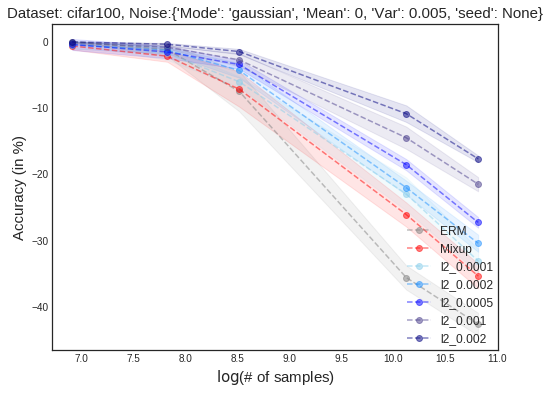

In [24]:
show_noise_gap_plot(data=data, split='train', mode='gaussian', var=0.005)

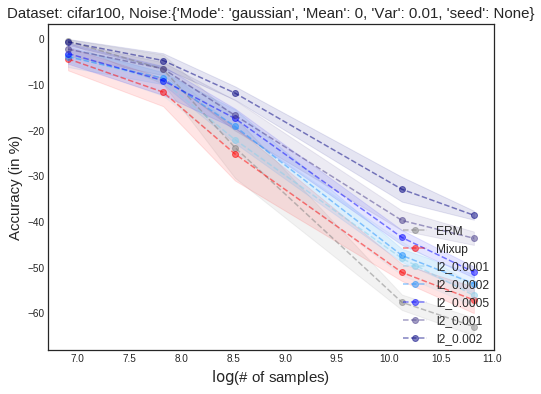

In [25]:
show_noise_gap_plot(data=data, split='train', mode='gaussian', var=0.01)

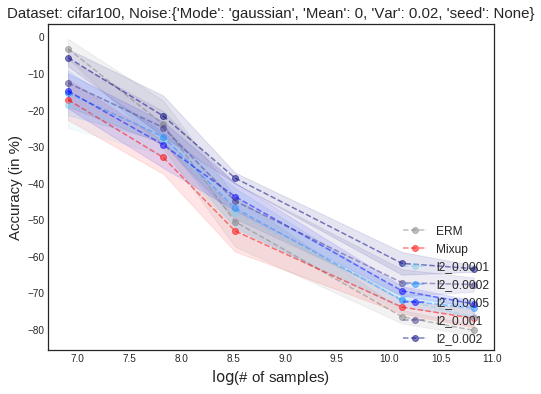

In [26]:
show_noise_gap_plot(data=data, split='train', mode='gaussian', var=0.02)

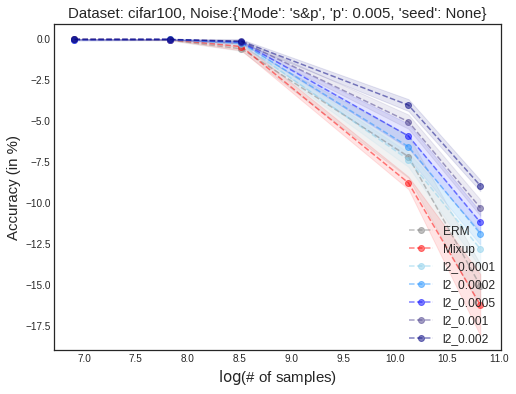

In [27]:
show_noise_gap_plot(data=data, split='train', mode='s&p', p=0.005)

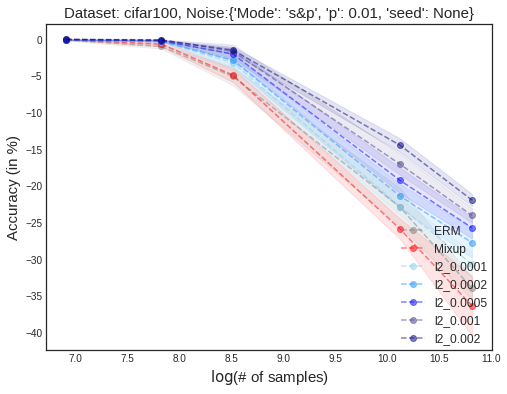

In [28]:
show_noise_gap_plot(data=data, split='train', mode='s&p', p=0.01)

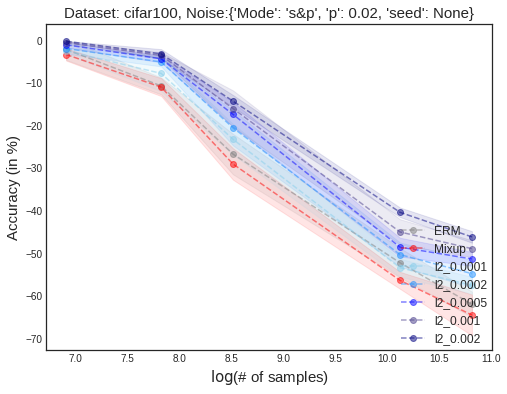

In [29]:
show_noise_gap_plot(data=data, split='train', mode='s&p', p=0.02)

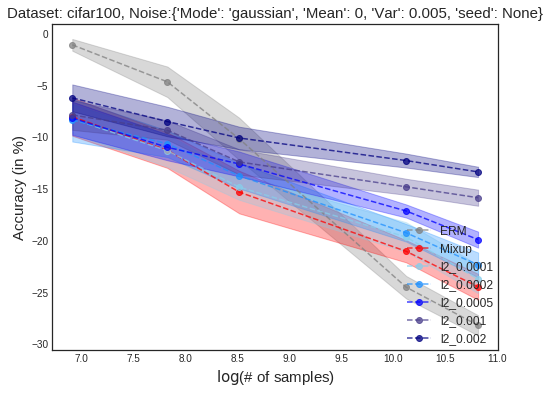

In [30]:
show_noise_gap_plot(data=data, split='test', mode='gaussian', var=0.005)

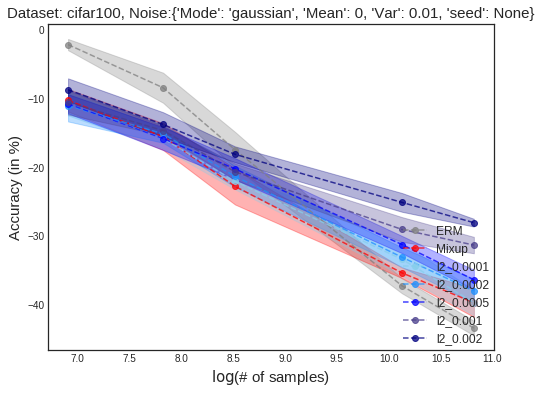

In [31]:
show_noise_gap_plot(data=data, split='test', mode='gaussian', var=0.01)

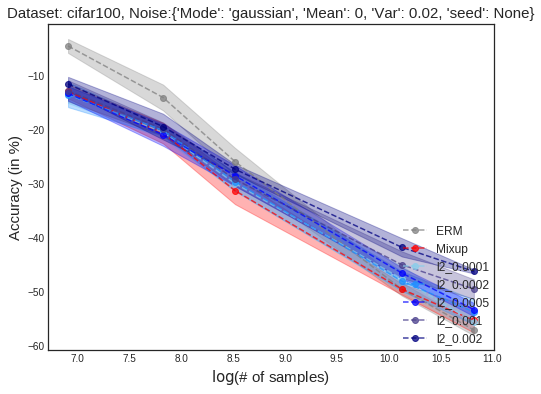

In [32]:
show_noise_gap_plot(data=data, split='test', mode='gaussian', var=0.02)

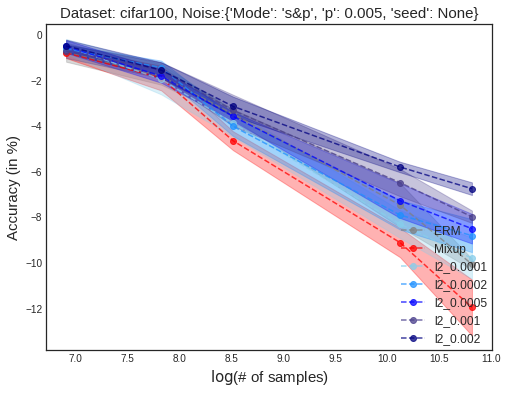

In [33]:
show_noise_gap_plot(data=data, split='test', mode='s&p', p=0.005)

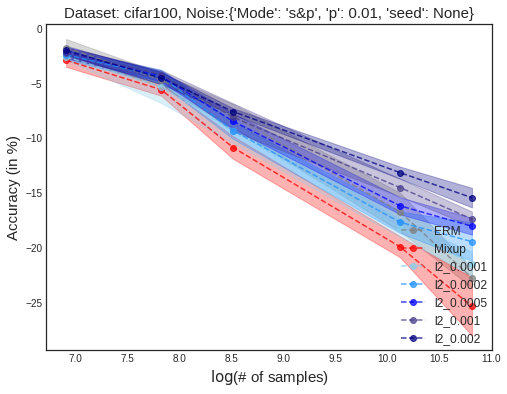

In [34]:
show_noise_gap_plot(data=data, split='test', mode='s&p', p=0.01)

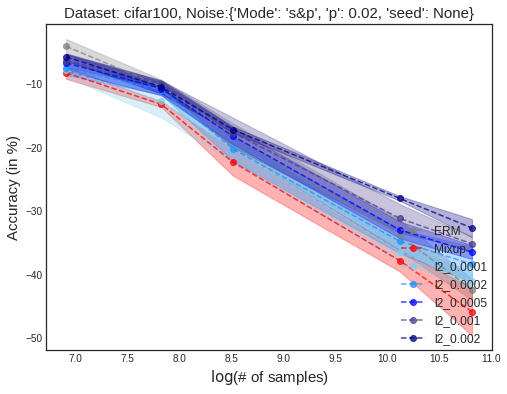

In [35]:
show_noise_gap_plot(data=data, split='test', mode='s&p', p=0.02)

# Experiments with Gradients (Under Construction)

In [36]:
def show_lipschitz_plot(data=dataset):
    df_data = summarize_gradients(data=data)
    if data == 'cifar10':
        x_list = [100,500,1000,2500,5000,25000,50000] # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = [1000,2500,5000,25000,50000] # np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    #models=['erm','mixup','l2_0.0005_','l2_0.0025_','l2_0.001_']
    #names=['ERM','Mixup','l2_0.0005','l2_0.0025','l2_0.001']
    #colors=['dodgerblue','yellowgreen','red','purple','blue']
    models=['l2_0.0005_','l2_0.001_','l2_0.0025_']
    names=['l2_0.0005','l2_0.001','l2_0.0025']
    colors=['dodgerblue','yellowgreen','red']
    
    
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel('Lipschitz', fontsize=15)
    plt.title('Dataset: {}'.format(data), fontsize=15)
    
    for i in range(len(colors)):
        ymean = df_data['mean'][df_data['model']==models[i]]
        yerr = df_data['std'][df_data['model']==models[i]]
        plt.plot(np.log(x_list), ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
        plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
    
    #plt.ylim(86,88)
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()
    

NameError: name 'dataset' is not defined

In [ ]:
def summarize_gradients(data=dataset):
    '''
    Summarize the gradients for each models
    '''
    
    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['erm','mixup','l2_0.0001','l2_0.0002']
    df = pd.DataFrame(columns=['data','model','sample', 'gradients'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(
                glob(
                    '../experiments/{}/{}*@{}-1/accuracies.txt'.format(model, data, sample)
                )
            )
            tmp = []
            for path in path_list:
                f = json.load(open(path_list[0], "r"))
                tmp = tmp + f['gradients']
            tmp_dict = {'data': data,
                        'model': model,
                        'sample': sample,
                        'gradients': tmp
                       }
            df = df.append(tmp_dict, ignore_index=True)
    return df

In [ ]:
def show_lipschitz_plot(data=dataset):
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel(r'$||\nabla_x h||_{\infty}$', fontsize=15)
    plt.title('Dataset: {}'.format(data), fontsize=15)
    df = summarize_gradients(dataset)
    x = df['sample'].drop_duplicates().values
    x_array = np.log(np.array(x, dtype='float32'))
    colors=['dodgerblue','yellowgreen','red','purple','blue']
    for i, model in enumerate(df['model'].drop_duplicates()):
        avg = np.array([])
        sd = np.array([])
        for sample in df['sample'].drop_duplicates():
            ind = (df['model'] == model) & (df['sample'] == sample)
            gradients = df['gradients'][ind].values[0]
            avg= np.append(avg, np.mean(gradients))
            sd= np.append(sd, np.std(gradients))
        plt.plot(x_array, avg, marker='o', label=model, color=colors[i], alpha=0.75)
        plt.fill_between(x_array, avg-sd, avg+sd, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
    
    plt.legend()
    plt.show()

In [ ]:
show_lipschitz_plot(dataset)

# Epochs vs Test accuracy

In [ ]:
def summarize_learning_history(data='cifar10'):
    
    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models=['erm','mixup','l2_0.0005_','l2_0.0025_','l2_0.001_']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(
                        glob(
                            '../experiments/acc_all/{}10*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)
                        ))
            tmp = []
            for path in path_list:
                f = json.load(open(path, "r"))
                tmp.append(pd.DataFrame(f, index=split_list))
            
            tmp = pd.concat(tmp, sort=False)
            test_acc = tmp.loc['test'].values
            
            try:
                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                           'mean': np.mean(test_acc, axis=0),
                           'std': np.std(test_acc, axis=0)}
            except:
                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                           'mean': list(test_acc),
                           'std': np.zeros(len(list(test_acc)))}
                
            
            df = df.append(tmp_dict, ignore_index=True)

    return df


In [ ]:
def plot_test_acc(data=dataset, sample=50000):
    df = summarize_learning_history(dataset)
    x_list = np.arange(100)
    
    models=['erm','mixup','l2_0.0005_','l2_0.001_','l2_0.0025_']
    names=['ERM','Mixup','l2_0.0005','l2_0.001','l2_0.0025']
    colors=['dodgerblue','yellowgreen','red','purple','blue']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Test accuracy (in %)', fontsize=15)
    plt.title('Dataset-sample size:{}-{}'.format(data,sample), fontsize=15)
    
    for i in range(len(colors)):
        ind = (df['model']==models[i]) & (df['sample']==sample)
        ymean = df['mean'][ind].values[0]
        yerr = df['std'][ind].values[0]
        plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.5) 
        plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
        
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    #plt.ylim(4,5.5)
    plt.show()

In [ ]:
plot_test_acc(data=dataset,sample=100)

In [ ]:
plot_test_acc(data=dataset,sample=500)

In [ ]:
plot_test_acc(data=dataset,sample=1000)

In [ ]:
plot_test_acc(data=dataset,sample=2500)

In [ ]:
plot_test_acc(data=dataset,sample=5000)

In [ ]:
plot_test_acc(data=dataset,sample=25000)

In [ ]:
plot_test_acc(data=dataset,sample=50000)